<p align="center"><img width="40%" src="logo/pytorch_logo_2018.svg" /></p>

--------------------------------------------------------------------------------

## 图像分类问题

PyTorch是一个非常强大的库，他可以解决许多问题，包括图像分类问题。 我们可能很难在通信领域中用到图像分类问题，但是图像是被处理为张量Tensor，然后再被模型学习的，所以如果数据和场景合适，我们是可以将这个方法套入其中的。本个教程采用[逻辑回归](https://en.wikipedia.org/wiki/Logistic_regression)算法进行分类。

### 1.导入训练数据


训练数据来源于PyTorch中自带的手写数字图片库。

In [20]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST
# Download training dataset
dataset = MNIST(root='data/', download=True)

查看数据，数据一共有60000个，其中测试集有10000个

In [21]:
print(len(dataset))
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

60000


10000

查看数据：数据包括一个图像和一个标签

Label: 5


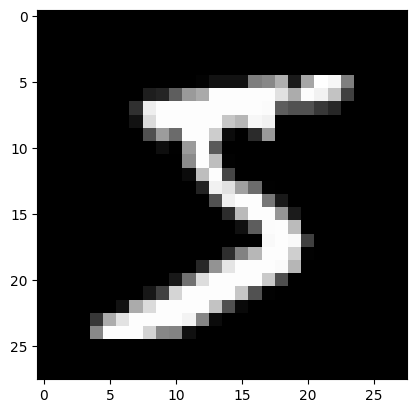

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)


还记得，我们之前的教程吗，我们要将数据转化为张量Tensor形式
数据现在转换为 1x28x28 张量。 第一个维度是颜色通道。 第二维和第三维分别表示沿图像高度和宽度的像素。 由于 MNIST 数据集中的图像是黑白的，因此只有一个通道。


In [23]:
import torchvision.transforms as transforms
# MNIST dataset (images and labels)
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


训练模型时，我们通常将模型分为训练集，测试集和验证集。
* 训练集 - 用于训练模型，即计算损失并使用梯度下降调整模型的权重。
* 验证集 - 用于在训练期间评估模型，调整超参数（学习率等），并选择模型的最佳版本。
* 测试集 - 用于比较不同的模型或方法并报告模型的最终准确度。



下面，我们从训练集中分出部分测试集，并把他们放在Dataloader中，便于后续的读取

In [24]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

### 2. 建立逻辑回归模型

逻辑回归模型基本与线性回归模型一致。 它包含权重和偏置矩阵，使用简单的矩阵运算（pred = x @ w.t() + b）获得输出。

In [25]:
import torch.nn as nn
import torch.nn.functional as F

input_size = 28*28
num_classes = 10

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

评估函数，用于检测模型的正确性

In [26]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

查看损失函数和准确率，可以看出我们的模型准确率不是很高，所以需要进行训练。

In [27]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.2904014587402344, 'val_acc': 0.09750790894031525}

### 3. 训练模型

定义一个fit函数来训练模型

In [28]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [29]:
history1 = fit(30, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9290, val_acc: 0.6476
Epoch [1], val_loss: 1.6650, val_acc: 0.7318
Epoch [2], val_loss: 1.4676, val_acc: 0.7637
Epoch [3], val_loss: 1.3183, val_acc: 0.7830
Epoch [4], val_loss: 1.2033, val_acc: 0.7975
Epoch [5], val_loss: 1.1127, val_acc: 0.8088
Epoch [6], val_loss: 1.0399, val_acc: 0.8150
Epoch [7], val_loss: 0.9803, val_acc: 0.8210
Epoch [8], val_loss: 0.9305, val_acc: 0.8265
Epoch [9], val_loss: 0.8883, val_acc: 0.8315
Epoch [10], val_loss: 0.8523, val_acc: 0.8353
Epoch [11], val_loss: 0.8211, val_acc: 0.8385
Epoch [12], val_loss: 0.7936, val_acc: 0.8410
Epoch [13], val_loss: 0.7694, val_acc: 0.8427
Epoch [14], val_loss: 0.7478, val_acc: 0.8448
Epoch [15], val_loss: 0.7285, val_acc: 0.8455
Epoch [16], val_loss: 0.7111, val_acc: 0.8467
Epoch [17], val_loss: 0.6952, val_acc: 0.8479
Epoch [18], val_loss: 0.6808, val_acc: 0.8496
Epoch [19], val_loss: 0.6675, val_acc: 0.8517
Epoch [20], val_loss: 0.6553, val_acc: 0.8525
Epoch [21], val_loss: 0.6441, val_acc: 0.853

我们可以看到，随着epoch的增加，准确率不断上升

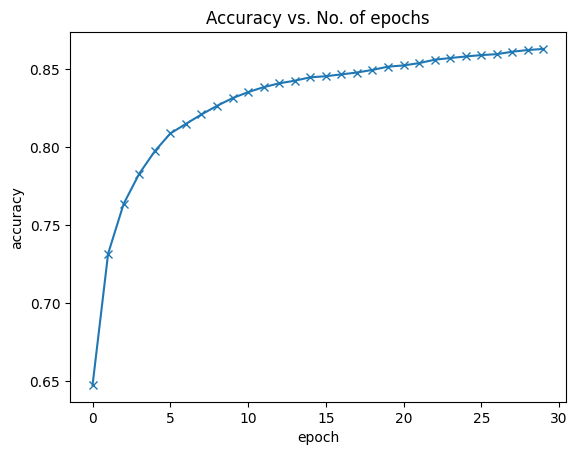

In [30]:
history = history1
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

### 4.测试模型

In [31]:
import torchvision.transforms as transforms
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

创建预测函数，查看预测值和真实值是否一致

In [32]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

从测试集中选取几个样本，查看预测值,可以看到预测值基本正确

Label: 7 , Predicted: 7
Label: 0 , Predicted: 0


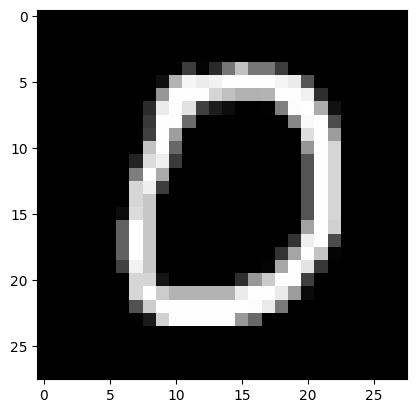

In [33]:
import matplotlib.pyplot as plt
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))